# Analysis
 - The temperature scatterplot shows highest temperatures to be just north of the equator on 7/1/19. This makes sense since it is the beginning of summer in the northern hemisphere.
 - City cloudiness looks to have no correlation with latitude. Also, the cloudiness measure doesn't appear to be as well distributed as others. There are bands at a couple different cloudiness values, like 0, 20, 80, 100. Perhaps there is another measure that correlates with cloudiness. More investigation would be needed.
 - Most humidity measurements are over 60%, no matter what latitude. Conversely, a majority of wind speed measurements are in the 

## Setup

#### Import dependencies

In [2]:
import pandas as pd
from citipy import citipy
import matplotlib.pyplot as plt
from config import api_key
import requests
import openweathermapy as owm
import random
import urllib
import csv

#### Set base url and temperature units

In [3]:
url = "http://api.openweathermap.org/data/2.5/weather?"
settings = {"units": "imperial", "appid": api_key}

## Random location function

- Step A: Use random functionality to get a list of randomly chosen coordinates
- Step B: Use CITIPY functionality to get a list of corresponding nearest locations
- Step C: Perform check that the list of locations is unique. If not, repeat steps A and B.

In [4]:
def list_of_locations(num):
    
    coordinates = []
    locations = []
        
    # Populate list of coordinates by generating 'num' random coordinate pairs,
    # each up to 3 decimal places
    for i in range(num):
        lat = round(random.uniform(-90,90), 3) # latitude values
        lon = round(random.uniform(-180,180), 3) # longitude values
        coordinates.append((lat, lon)) 
    
    # Populate lists of locations denoted by cities and corresponding country codes
    # which are nearest to the randomly chosen coordinates found above
    for coordinate_pair in coordinates:
        (lat, lon) = coordinate_pair
        city = citipy.nearest_city(lat, lon)
        locations.append(city.city_name + "," + city.country_code)
    
    # Remove any duplicates from the list.
    unique_locations = []
    
    for x in locations: 
        if x not in unique_locations: 
            unique_locations.append(x)
        locations = unique_locations
        
    return locations

## Store JSON responses from API

In [6]:
# Set the variable for number of locations. Note that filtering in list_of_locations function
# ends up approximately divides this value by 3.
num_locations = 1600

# Define list to store JSON responses from API calls based on locations (i.e., city and country code names)
responses = []

# Run the function to populate the locations
locations = list_of_locations(num_locations)

In [7]:
# Take lists of locations and ping API with them. Store JSON in a new list called responses.
for location in locations:
    try:
        response = owm.get_current(location, **settings)
        responses.append(response)
        city_name = response.get('name')
        city_number = response.get('id')
        #print(f"The city of {city_name} has the city number of {city_number}.")
    except urllib.error.HTTPError as error: 
        pass

## Build the CSV

In [8]:
with open('./Resources/reponses.csv', 'w', newline='') as csv_file:
    csvwriter = csv.writer(csv_file, delimiter=',')
    csvwriter.writerow(['coord_lat', 'coord_lon', 'weather_id', 'weather_main', 'weather_description', 'weather_icon', 'base', 'main_temp', 'main_pressure', 'main_humidity', 'main_temp_min', 'main_temp_max', 'visibility', 'wind_speed', 'wind_deg', 'clouds_all', 'dt', 'sys_type', 'sys_id', 'sys_message', 'sys_country', 'sys_sunrise', 'sys_sunset', 'timezone', 'id', 'name', 'cod'])
    
    for response in responses:
        coord_lat = response['coord'].get('lat')
        coord_lon = response['coord'].get('lon')
       
        weather_id = response['weather'][0].get('id')
        weather_main = response['weather'][0].get('main')
        weather_description = response['weather'][0].get('description')
        weather_icon = response['weather'][0].get('icon')
        
        base = response.get('base')
        
        main_temp = response['main'].get('temp')
        main_pressure = response['main'].get('pressure')
        main_humidity = response['main'].get('humidity')
        main_temp_min = response['main'].get('temp_min')
        main_temp_max = response['main'].get('temp_max')
        
        visibility = response.get('visibility')
        
        wind_speed = response['wind'].get('speed')
        wind_deg = response['wind'].get('deg')
        
        clouds_all = response['clouds'].get('all')
        dt = response.get('dt')
        
        sys_type = response['sys'].get('type')
        sys_id = response['sys'].get('id')
        sys_message = response['sys'].get('message')
        sys_country = response['sys'].get('country')
        sys_sunrise = response['sys'].get('sunrise')
        sys_sunset = response['sys'].get('sunset')
        
        timezone = response.get('timezone')
        __id__ = response.get('id')
        name = response.get('name')
        cod = response.get('cod')
        csvwriter.writerow([coord_lat, coord_lon, weather_id, weather_main, weather_description, weather_icon, base, main_temp, main_pressure, main_humidity, main_temp_min, main_temp_max, visibility, wind_speed, wind_deg, clouds_all, dt, sys_type, sys_id, sys_message, sys_country, sys_sunrise, sys_sunset, timezone, __id__, name, cod])

## Build the dataframe

In [9]:
# Define a summary list of metrics I want to pull from the responses list
summary = ['name', 'coord.lat', 'main.temp', 'main.humidity', 'wind.speed', 'clouds.all']

# Create a Pandas DataFrame with the results, indexed by city name since this data will not be called by scatterplots
data_slice = [response(*summary) for response in responses]
data_df = pd.DataFrame(data_slice)
data_df.columns = ['city_name', 'latitude', 'temperature', 'humidity_percentage', 'wind_speed_mph', 'cloudiness_percentage']
data_df = data_df.set_index('city_name')
data_df = data_df[data_df['humidity_percentage'] <= 100] # Include this line because a couple humidity measurements were wacky (close to 300%)
data_df.head()

,latitude,temperature,humidity_percentage,wind_speed_mph,cloudiness_percentage
city_name,,,,,
Provideniya,64.42,41.26,99,12.12,100
Punta Arenas,-53.16,41.45,48,19.46,0
Kavieng,-2.57,83.20,67,2.42,10
Barrow,39.51,85.10,58,12.75,1
Talnakh,69.49,28.40,86,13.42,0


## Build scatterplots

#### Define scatterplot function

In [11]:
def scatter(column, title, y_axis_label, file_name):
    plt.scatter(data_df['latitude'], data_df[column], c='b', marker='o', zorder=1)
    plt.title(title, size='xx-large', fontweight='bold', pad=20)
    plt.xlabel('Latitude Coordinate', size='large', labelpad=10)
    plt.ylabel(y_axis_label, size='large', labelpad=10)
    plt.savefig(file_name)
    plt.show()

#### Call scatterplot function for 4 pairs of metrics

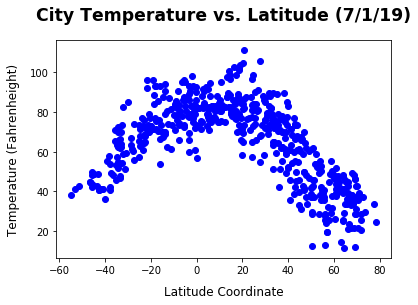

In [12]:
scatter('temperature', 'City Temperature vs. Latitude (7/1/19)', 'Temperature (Fahrenheight)', './Graphs/temperature_vs_latitude')

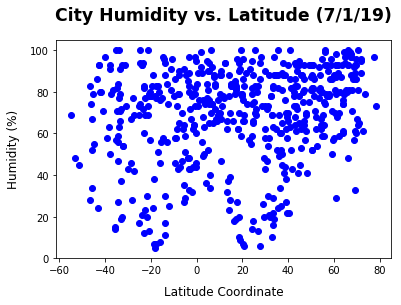

In [13]:
scatter('humidity_percentage', 'City Humidity vs. Latitude (7/1/19)', 'Humidity (%)', './Graphs/humidity_vs_latitude')

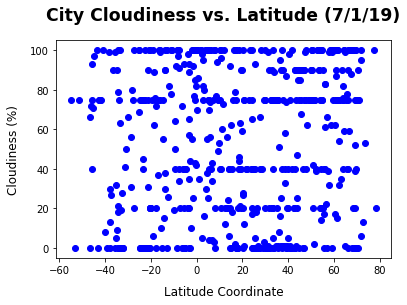

In [14]:
scatter('cloudiness_percentage', 'City Cloudiness vs. Latitude (7/1/19)', 'Cloudiness (%)', './Graphs/cloudiness_vs_latitude')

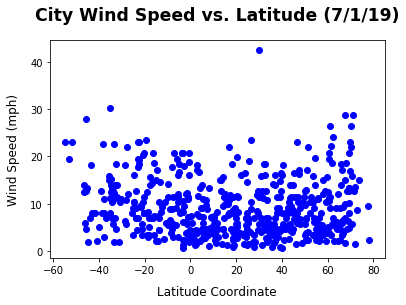

In [15]:
scatter('wind_speed_mph', 'City Wind Speed vs. Latitude (7/1/19)', 'Wind Speed (mph)', './Graphs/windspeed_vs_latitude')